In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from data_module import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D,Conv2D,MaxPooling2D
from tensorflow.keras.layers import Dropout,Lambda
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import tensorflow as tf

### read data with col names

In [2]:
col_names=['name', 'fullname', 'type', 'extra1', 'extra2', 'dataset', 'extra3'] 
df = pd.read_csv("/home/anirudh_seth/Dataset/test_split_v5.txt",sep=",",names = col_names)

### a sample of a row of dataset

In [3]:
df.iloc[0]

name            dd889560-0c25-4b6d-9108-074a1ae843c7
fullname    dd889560-0c25-4b6d-9108-074a1ae843c7.png
type                                          normal
extra1                                           NaN
extra2                                           NaN
dataset                                        train
extra3                                           NaN
Name: 0, dtype: object

### open and show a file

In [5]:
df.iloc[0]['fullname']

'dd889560-0c25-4b6d-9108-074a1ae843c7.png'

In [6]:
img = cv2.imread("/home/anirudh_seth/Dataset/test2/" + df.iloc[0]['fullname'])

In [7]:
img.shape

(1024, 1024, 3)

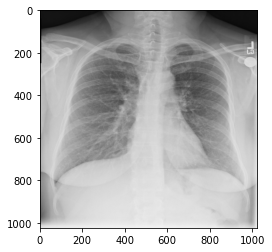

In [7]:
plt.imshow(img)

# Data loader test

In [8]:
Testgenerator = BalanceCovidDataset(data_dir="/home/anirudh_seth/Dataset",
                                csv_file="/home/anirudh_seth/Dataset/test_split_v5.txt",
                                covid_percent=0.3,
                                batch_size=100,
                                is_training=False,
                                augmentation=False,
                                class_weights=[1., 1., 12]) #weights for normal, pneumonia, covid19

In [13]:
Traingenerator = BalanceCovidDataset(data_dir="/home/anirudh_seth/Dataset",
                                csv_file="/home/anirudh_seth/Dataset/train_split_v5.txt",
                                covid_percent=0.3,
                                batch_size=100,
                                is_training=True,
                                augmentation=False,
                                class_weights=[1., 1., 12]) #weights for normal, pneumonia, covid19

In [14]:
Valgenerator = BalanceCovidDataset(data_dir="/home/anirudh_seth/Dataset",
                                csv_file="/home/anirudh_seth/Dataset/val_split_v5.txt",
                                covid_percent=0.3,
                                batch_size=100,
                                is_training=False,
                                isValidation=True,
                                augmentation=False,
                                class_weights=[1., 1., 12]) #weights for normal, pneumonia, covid19

In [15]:
def checkDistribution(gen):
    for i in range(len(gen)):
        distribution=next(Traingenerator)[1]
        print('Batch ',i,' : ',np.sum(distribution,axis=0))

In [16]:
tensorboard_callback =tf.keras.callbacks.TensorBoard(
    log_dir='logs_exp3', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='batch', profile_batch=2, embeddings_freq=0
)

checkpoint_filepath = 'checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_freq='epoch',
    save_best_only=False)


In [17]:


baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Conv2D(512, (3, 3), activation=tf.nn.relu,name='block6_conv1')(headModel)
headModel = Conv2D(512, (3, 3), activation=tf.nn.relu,name='block6_conv2')(headModel)
headModel = MaxPooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [ ]:
opt = Adam(lr=0.001, decay=0.001 / 10)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(Traingenerator,validation_data=Valgenerator,verbose=1,epochs=50,callbacks=[tensorboard_callback,model_checkpoint_callback])

[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 108 steps, validate for 27 steps
Epoch 1/50
108/108 [==============================] - 630s 6s/step - loss: 0.8326 - accuracy: 0.6464 - val_loss: 0.7780 - val_accuracy: 0.6237
Epoch 2/50
108/108 [==============================] - 446s 4s/step - loss: 0.6077 - accuracy: 0.7580 - val_loss: 0.6047 - val_accuracy: 0.7993
Epoch 3/50
108/108 [==============================] - 447s 4s/step - loss: 0.4382 - accuracy: 0.8366 - val_loss: 0.5656 - val_accuracy: 0.8019
Epoch 4/50
108/108 [==============================] - 666s 6s/step - loss: 0.3683 - accuracy: 0.8696 - val_loss: 0.5220 - val_accuracy: 0.8304
Epoch 5/50
108/108 [==============================] - 420s 4s/step - loss: 0.3306 - accuracy: 0.8866 - val_loss: 0.8130 - val_accuracy: 0.7674
Epoch 6/50
108/108 [==============================] - 451s 4s/step - loss: 0.3084 - accuracy

In [ ]:
model.save('model_exp3')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'],label='train_loss')
plt.plot(model.history.history['val_loss'],label='val_loss')
plt.title('Loss')
plt.legend()

In [ ]:
plt.plot(model.history.history['accuracy'],label='train_accuracy')
plt.plot(model.history.history['val_accuracy'],label='val_accuracy')
plt.title('Loss')
plt.legend()